In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
from solver import *
from psiop import *

# psiOp quantization and evolution simulation

## Kohn–Nirenberg Quantization with FFT

### 1D influence of parameters: freq_windows, clamp_values and space_windows

#### Basic case


*********************************
* Partial differential equation *
*********************************

     ⎛ 2    2          ⎞    
psiOp⎝x  + ξ  + 1, u(x)⎠ = 0

********************
* Equation parsing *
********************


Equation rewritten in standard form: psiOp(x**2 + xi**2 + 1, u(x))
⚠️ psiOp detected: skipping expansion for safety

Expanded equation: psiOp(x**2 + xi**2 + 1, u(x))
Analyzing term: psiOp(x**2 + xi**2 + 1, u(x))
  --> Classified as pseudo linear term (psiOp)
Final linear terms: {}
Final nonlinear terms: []
Symbol terms: []
Pseudo terms: [(1, x**2 + xi**2 + 1)]
Source terms: []
⚠️  Pseudo‑differential operator detected: all other linear terms have been rejected.
⚠️ For psiOp, use interactive_symbol_analysis.


/home/fifi/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/fifi/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


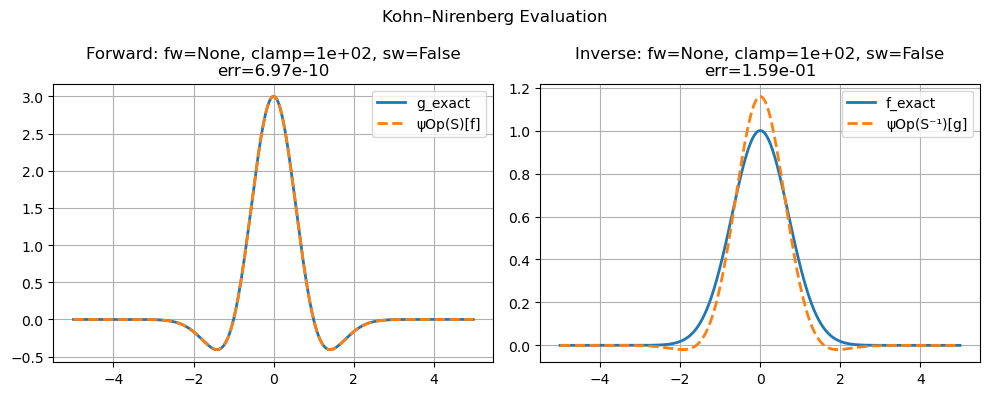

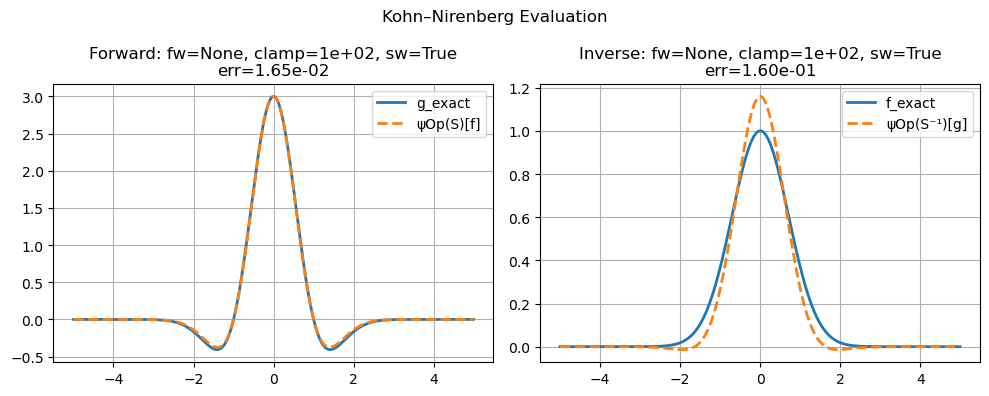

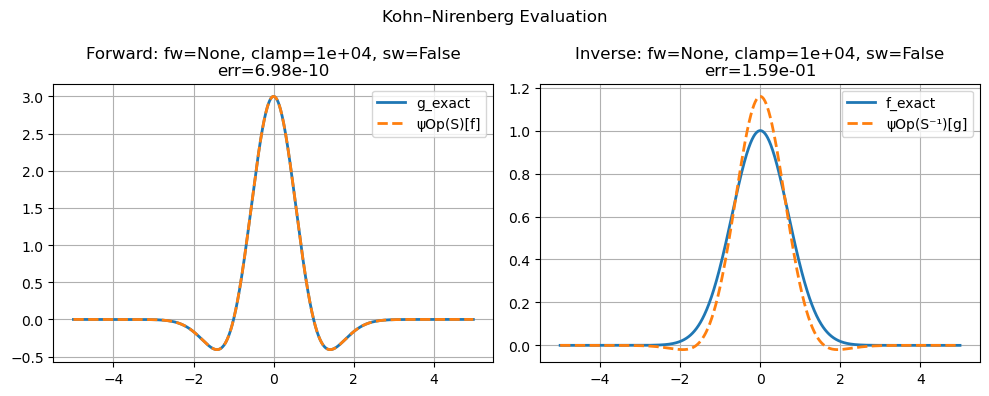

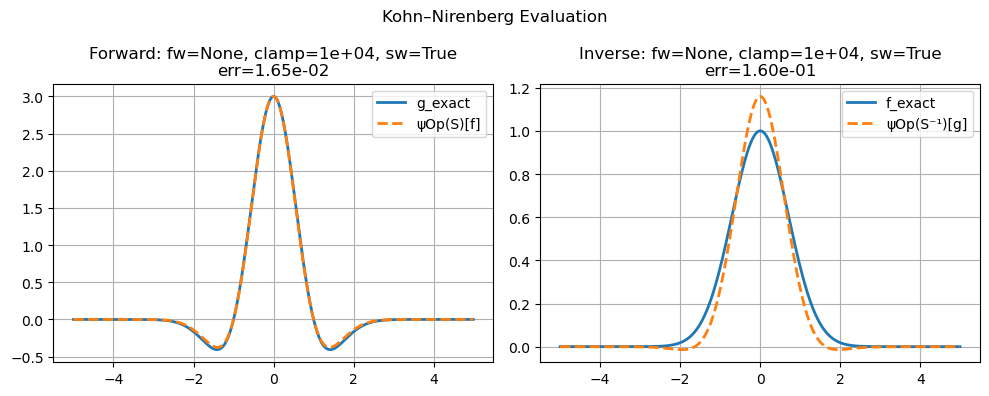

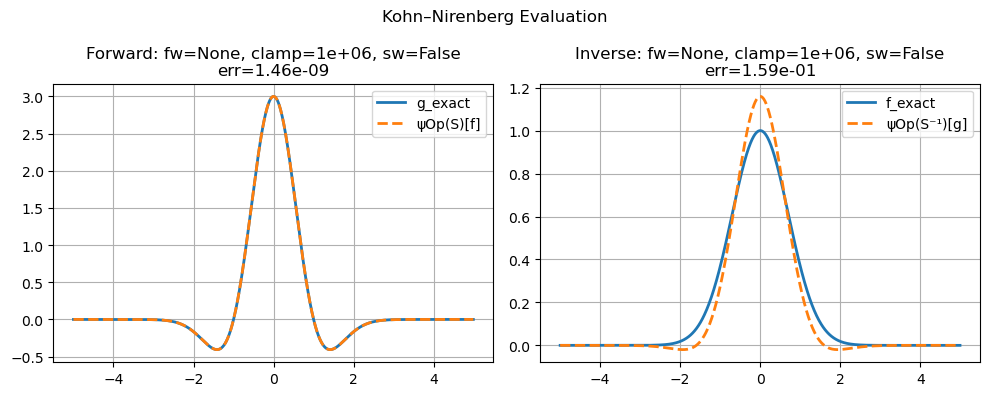

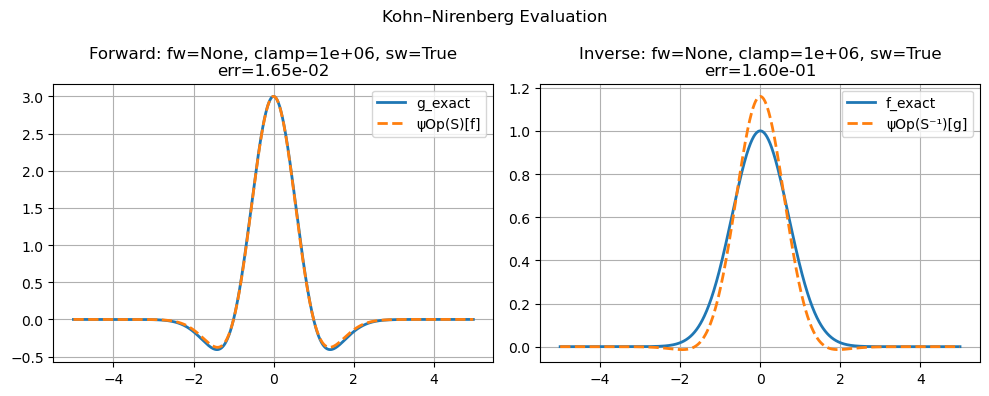

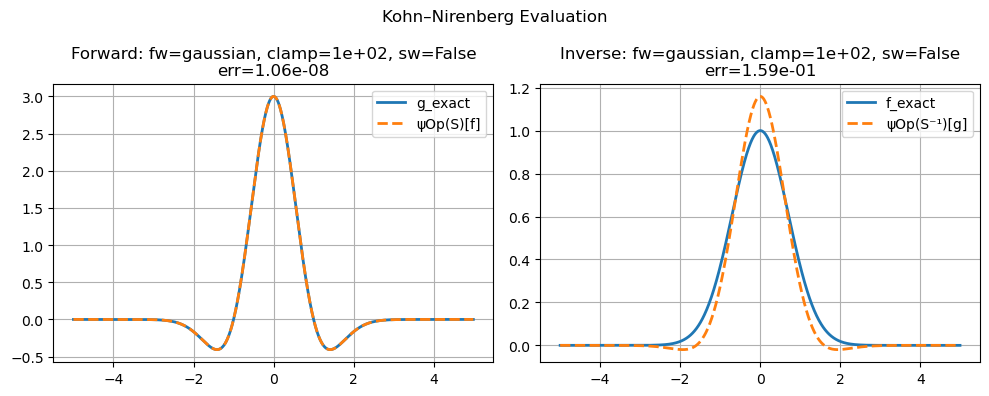

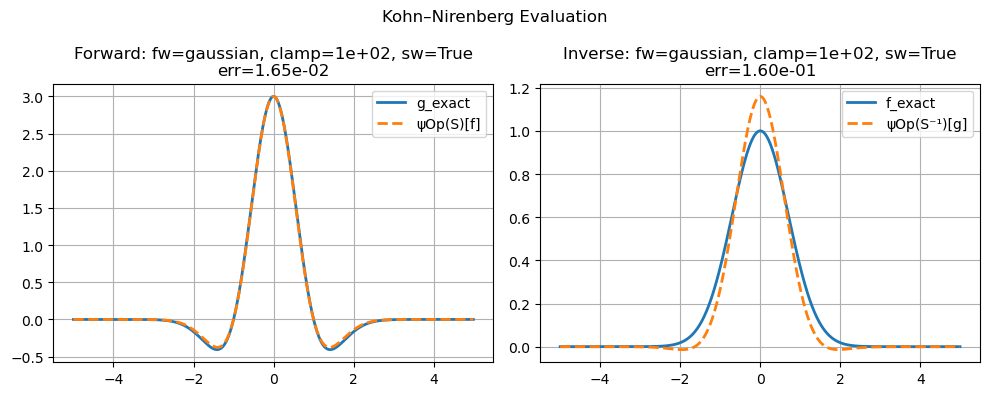

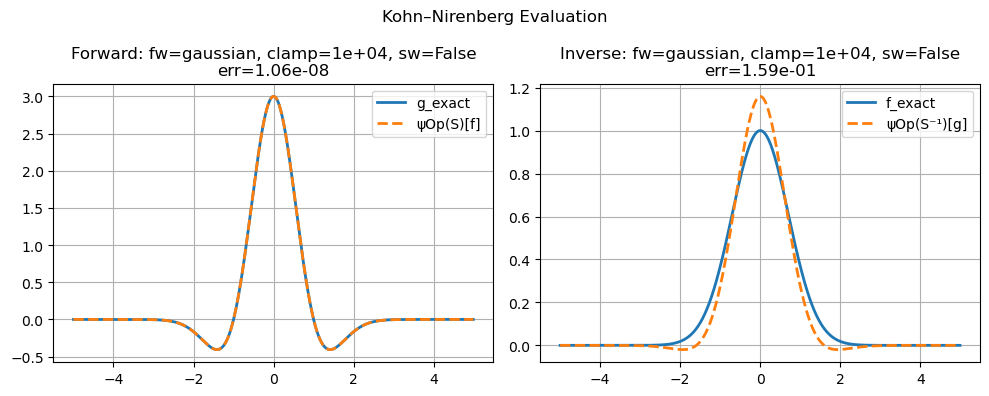

In [ ]:
# --- Define symbols and dummy equation ---
x, xi = symbols('x xi', real=True)
u = Function('u')(x)
equation = Eq(psiOp(x**2 + xi**2 + 1, u), 0)

# --- Initialize the solver ---
solver = PDESolver(equation)
L = 10
N = 1024
solver.setup(Lx=L, Nx=N)

# --- Define test input and target output ---
x_grid = solver.x_grid
f_exact = np.exp(-x_grid**2)
g_exact = 3 * (1 - x_grid**2) * f_exact

# --- Define the symbol and its inverse ---
def S(x, xi):
    return x**2 + xi**2 + 1

def S_inv(x, xi):
    return 1.0 / (S(x, xi) + 1e-10)

# --- Parameter combinations to test ---
freq_windows = [None, 'gaussian', 'hann']
clamp_values = [1e2, 1e4, 1e6]
space_windows = [False, True]

combinations = list(product(freq_windows, clamp_values, space_windows))

# --- Store errors for analysis ---
results = []

# --- Loop over parameter configurations ---
for i, (fw, clamp, sw) in enumerate(combinations):

    label = f"fw={fw}, clamp={clamp:.0e}, sw={sw}"

    # --- Apply operator ψOp(S)[f] ---
    g_approx = solver.kohn_nirenberg_fft(f_exact, symbol_func=S,
                                         freq_window=fw,
                                         clamp=clamp,
                                         space_window=sw)

    # --- Compute forward error ---
    err_forward = np.linalg.norm(g_exact - g_approx) / np.linalg.norm(g_exact)

    # --- Apply inverse ψOp(S⁻¹)[g] ---
    f_approx = solver.kohn_nirenberg_fft(g_approx, symbol_func=S_inv,
                                         freq_window=fw,
                                         clamp=clamp,
                                         space_window=sw)

    # --- Compute inverse error ---
    err_inverse = np.linalg.norm(f_exact - f_approx) / np.linalg.norm(f_exact)

    # --- Save results ---
    results.append((fw, clamp, sw, err_forward, err_inverse))

    # --- Plot results for this configuration ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x_grid, g_exact, label='g_exact', lw=2)
    plt.plot(x_grid, g_approx, '--', label='ψOp(S)[f]', lw=2)
    plt.title(f"Forward: {label}\nerr={err_forward:.2e}")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x_grid, f_exact, label='f_exact', lw=2)
    plt.plot(x_grid, f_approx, '--', label='ψOp(S⁻¹)[g]', lw=2)
    plt.title(f"Inverse: {label}\nerr={err_inverse:.2e}")
    plt.grid(True)
    plt.legend()

    plt.suptitle("Kohn–Nirenberg Evaluation")
    plt.tight_layout()
    plt.show()

# --- Summary Table ---
print("\nSummary of Relative Errors:")
print(f"{'FreqWin':>10} {'Clamp':>10} {'SpaceWin':>10} {'ErrFwd':>12} {'ErrInv':>12}")
for fw, clamp, sw, err1, err2 in results:
    print(f"{str(fw):>10} {clamp:10.0e} {str(sw):>10} {err1:12.2e} {err2:12.2e}")


#### Advanced case

In [ ]:
# --- Variables symboliques ---
x, xi = symbols('x xi', real=True)
u = Function('u')(x)
p_expr = (1 + 0.5 * sin(3 * x)) * xi**2
equation = Eq(psiOp(p_expr, u), 0)

# --- Initialisation du solveur 1D ---
solver1d = PDESolver(equation)
L = 10.0
N = 1024
solver1d.setup(Lx=L, Nx=N)

X = solver1d.X
KX = solver1d.KX

# --- Fonction d'entrée : onde sinusoïdale localisée ---
f_exact = np.exp(-X**2) * np.cos(10 * X)

# --- Symbole et inverse ---
def p_lens(x, xi):
    return (1 + 0.5 * np.sin(3 * x)) * xi**2

def p_lens_inv(x, xi):
    return 1.0 / (p_lens(x, xi) + 1e-6)

# --- Store errors and amplification ratio ---
results = []

# --- Parameter combinations to test ---
freq_windows = [None, 'gaussian', 'hann']
clamp_values = [1e2, 1e4, 1e6]
space_windows = [False, True]

combinations = list(product(freq_windows, clamp_values, space_windows))

# --- Loop over parameter configurations ---
for i, (fw, clamp, sw) in enumerate(combinations):

    label = f"fw={fw}, clamp={clamp:.0e}, sw={sw}"

    # --- Apply operator ψOp(S)[f] ---
    g_approx = solver1d.kohn_nirenberg_fft(f_exact, symbol_func=p_lens,
                                           freq_window=fw,
                                           clamp=clamp,
                                           space_window=sw)

    # --- Compute amplification ---
    ampl_ratio = np.linalg.norm(g_approx) / np.linalg.norm(f_exact)

    # --- Apply inverse ψOp(S⁻¹)[g] ---
    f_approx = solver1d.kohn_nirenberg_fft(g_approx, symbol_func=p_lens_inv,
                                           freq_window=fw,
                                           clamp=clamp,
                                           space_window=sw)

    # --- Compute inverse error ---
    err_inverse = np.linalg.norm(f_exact - f_approx) / np.linalg.norm(f_exact)

    # --- Save results ---
    results.append((fw, clamp, sw, ampl_ratio, err_inverse))

    # --- Plot results for this configuration ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(X, g_approx.real, '--', label='ψOp(S)[f]', lw=2)
    plt.title(f"Forward: {label}\n‖g‖/‖f‖ = {ampl_ratio:.2e}")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(X, f_exact, label='f_exact', lw=2)
    plt.plot(X, f_approx.real, '--', label='ψOp(S⁻¹)[g]', lw=2)
    plt.title(f"Inverse: {label}\nerr={err_inverse:.2e}")
    plt.grid(True)
    plt.legend()

    plt.suptitle("Kohn–Nirenberg 1D Evaluation")
    plt.tight_layout()
    plt.show()

# --- Summary Table ---
print("\nSummary of Amplification and Inversion Errors:")
print(f"{'FreqWin':>10} {'Clamp':>10} {'SpaceWin':>10} {'‖g‖/‖f‖':>12} {'ErrInv':>12}")
for fw, clamp, sw, ampl, err2 in results:
    print(f"{str(fw):>10} {clamp:10.0e} {str(sw):>10} {ampl:12.2e} {err2:12.2e}")


### 2D influence of parameters: freq_windows, clamp_values and space_windows

#### Basic case

In [ ]:
# --- Definition of symbolic variables ---
x, y, xi, eta = symbols('x y xi eta', real=True)
u = Function('u')(x, y)

# --- Definition of the symbol and associated equation ---
expr_symbol = x**2 + y**2 + xi**2 + eta**2 + 1
equation = Eq(psiOp(expr_symbol, u), 0)  # Placeholder to initialize the solver

# --- Initialization of the 2D solver ---
solver = PDESolver(equation)
L = 10.0
N = 64 # Reduced to avoid MemoryError
solver.setup(Lx=L, Ly=L, Nx=N, Ny=N)

# --- Creation of the spatial grid ---
X, Y = solver.X, solver.Y

# --- Test function: Centered Gaussian ---
f_exact = np.exp(-(X**2 + Y**2))

# --- Target output: Op(p)[f] = (-3 x² - 3 y² + 5) * f_exact ---
g_exact = (-3 * X**2 - 3 * Y**2 + 5) * f_exact

# --- Definition of the symbol and its inverse ---
def S(x_val, y_val, xi_val, eta_val):
    return x_val**2 + y_val**2 + xi_val**2 + eta_val**2 + 1

def S_inv(x_val, y_val, xi_val, eta_val):
    return 1.0 / (S(x_val, y_val, xi_val, eta_val) + 1e-10)

# --- Parameters to test ---
freq_windows = [None, 'gaussian', 'hann']
clamp_values = [1e2, 1e4, 1e6]
space_windows = [False, True]

combinations = list(product(freq_windows, clamp_values, space_windows))
results = []

# --- Loop over parameter combinations ---
for i, (fw, clamp, sw) in enumerate(combinations):

    label = f"fw={fw}, clamp={clamp:.0e}, sw={sw}"

    # --- Application of the operator ψOp(S)[f] ---
    g_approx = solver.kohn_nirenberg_fft(f_exact, symbol_func=S,
                                         freq_window=fw,
                                         clamp=clamp,
                                         space_window=sw)

    # --- Direct error ---
    err_forward = np.linalg.norm(g_exact - g_approx) / np.linalg.norm(g_exact)

    # --- Application of the inverse ψOp(S⁻¹)[g] ---
    f_approx = solver.kohn_nirenberg_fft(g_approx, symbol_func=S_inv,
                                         freq_window=fw,
                                         clamp=clamp,
                                         space_window=sw)

    # --- Inverse error ---
    err_inverse = np.linalg.norm(f_exact - f_approx) / np.linalg.norm(f_exact)

    results.append((fw, clamp, sw, err_forward, err_inverse))

    # --- Visualization ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    extent = [-L/2, L/2, -L/2, L/2]

    im = axes[0, 0].imshow(f_exact, extent=extent, origin='lower', cmap='viridis')
    plt.colorbar(im, ax=axes[0, 0])
    axes[0, 0].set_title("Exact Input f(x,y)")

    im = axes[0, 1].imshow(g_exact, extent=extent, origin='lower', cmap='viridis')
    plt.colorbar(im, ax=axes[0, 1])
    axes[0, 1].set_title(f"Exact Output g(x,y)\n{label}")

    im = axes[1, 0].imshow(g_approx.real, extent=extent, origin='lower', cmap='viridis')
    plt.colorbar(im, ax=axes[1, 0])
    axes[1, 0].set_title(f"Approx Output ψOp(S)[f]\nerr={err_forward:.2e}")

    im = axes[1, 1].imshow(f_approx.real, extent=extent, origin='lower', cmap='viridis')
    plt.colorbar(im, ax=axes[1, 1])
    axes[1, 1].set_title(f"Reconstructed f ≈ ψOp(S⁻¹)[g]\nerr={err_inverse:.2e}")

    plt.suptitle("2D Kohn–Nirenberg Evaluation")
    plt.tight_layout()
    plt.show()

# --- Summary table of errors ---
print("\nSummary of Relative Errors:")
print(f"{'FreqWin':>10} {'Clamp':>10} {'SpaceWin':>10} {'ErrFwd':>12} {'ErrInv':>12}")
for fw, clamp, sw, err1, err2 in results:
    print(f"{str(fw):>10} {clamp:10.0e} {str(sw):>10} {err1:12.2e} {err2:12.2e}")


#### Advanced case

In [ ]:
# --- Symbolic setup ---
x, y, xi, eta = symbols('x y xi eta', real=True)
u = Function('u')(x, y)

# --- Equation placeholder (symbol will be passed numerically) ---
symbol_expr = (1 + 0.5 * cos(3*x) * sin(2*y)) * (xi**2 + eta**2)
equation = Eq(psiOp(symbol_expr, u), 0)
solver = PDESolver(equation)

# --- Grid parameters ---
L = 10.0
N = 64
solver.setup(Lx=L, Ly=L, Nx=N, Ny=N)
X, Y = solver.X, solver.Y
KX, KY = solver.KX, solver.KY

# --- Test function: oscillating Gaussian (like a modulated laser beam) ---
f_exact = np.exp(-(X**2 + Y**2)) * np.cos(10 * X)

# --- Symbol definition ---
def p_quantum_lens(x, y, xi, eta):
    mod = 1.0 + 0.5 * np.cos(3 * x) * np.sin(2 * y)
    return mod * (xi**2 + eta**2)

def p_quantum_lens_inv(x, y, xi, eta):
    return 1.0 / (p_quantum_lens(x, y, xi, eta) + 1e-6)

# --- Parameters to explore ---
freq_windows = [None, 'gaussian', 'hann']
space_windows = [False, True]
clamp = 1e4  # Fixed clamp to avoid instability
combinations = list(product(freq_windows, space_windows))

# --- Storage for summary ---
results = []

# --- Main loop ---
for fw, sw in combinations:
    label = f"fw={fw}, sw={sw}"

    g_approx = solver.kohn_nirenberg_fft(f_exact,
                                         symbol_func=p_quantum_lens,
                                         freq_window=fw,
                                         space_window=sw,
                                         clamp=clamp)

    # --- Compute centered spectra ---
    F_spec = np.log1p(np.abs(fftshift(fft2(f_exact))))
    G_spec = np.log1p(np.abs(fftshift(fft2(g_approx))))
    
    # --- Frequency axes for plotting (optional but helpful) ---
    freq_extent = [-N/2, N/2, -N/2, N/2]
    
    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(F_spec, extent=freq_extent, origin='lower', cmap='plasma')
    axes[0].set_title("FFT of f_exact")
    axes[0].set_xlabel("ξ")
    axes[0].set_ylabel("η")
    
    axes[1].imshow(G_spec, extent=freq_extent, origin='lower', cmap='plasma')
    axes[1].set_title("FFT of g_approx = ψOp(p)[f]")
    axes[1].set_xlabel("ξ")
    axes[1].set_ylabel("η")
    
    plt.suptitle("Frequency content: input vs amplified output")
    plt.tight_layout()
    plt.show()


    f_recon = solver.kohn_nirenberg_fft(g_approx,
                                        symbol_func=p_quantum_lens_inv,
                                        freq_window=fw,
                                        space_window=sw,
                                        clamp=clamp)

    err_forward = np.linalg.norm(g_approx) / np.linalg.norm(f_exact)
    err_inverse = np.linalg.norm(f_exact - f_recon) / np.linalg.norm(f_exact)

    results.append((fw, sw, err_forward, err_inverse))

    # --- Visualization ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    extent = [-L/2, L/2, -L/2, L/2]

    im = axes[0, 0].imshow(f_exact, extent=extent, origin='lower', cmap='viridis')
    plt.colorbar(im, ax=axes[0, 0])
    axes[0, 0].set_title("Input: oscillating Gaussian")

    im = axes[0, 1].imshow(g_approx.real, extent=extent, origin='lower', cmap='magma')
    plt.colorbar(im, ax=axes[0, 1])
    axes[0, 1].set_title(f"ψOp(p)[f] {label}\n(norm={err_forward:.2e})")

    im = axes[1, 0].imshow(f_recon.real, extent=extent, origin='lower', cmap='viridis')
    plt.colorbar(im, ax=axes[1, 0])
    axes[1, 0].set_title(f"Reconstructed f ≈ ψOp(p⁻¹)[g]")

    im = axes[1, 1].imshow((f_recon - f_exact).real, extent=extent, origin='lower', cmap='inferno')
    plt.colorbar(im, ax=axes[1, 1])
    axes[1, 1].set_title(f"Error f - f_recon\n(err={err_inverse:.2e})")

    plt.suptitle(f"Kohn–Nirenberg Diffraction Test\n{label}")
    plt.tight_layout()
    plt.show()

# --- Summary table of errors ---
print("\nSummary of Relative Errors:")
print(f"{'FreqWin':>10} {'SpaceWin':>10} {'ErrFwd':>12} {'ErrInv':>12}")
for fw, sw, err1, err2 in results:
    print(f"{str(fw):>10} {str(sw):>10} {err1:12.2e} {err2:12.2e}")


## Non-periodic Kohn–Nirenberg Quantization 

### 1D

#### Basic case

In [ ]:
# --- Define symbols and dummy equation ---
x, xi = symbols('x xi', real=True)
u = Function('u')(x)
equation = Eq(psiOp(x**2 + xi**2 + 1, u), 0)

# --- Initialize the solver ---
solver = PDESolver(equation)
L = 10
N = 1024
solver.setup(Lx=L, Nx=N)

# --- Define test input and target output ---
x_grid = solver.x_grid
xi_grid = np.linspace(-20, 20, 1024)
f_exact = np.exp(-x_grid**2)
g_exact = 3 * (1 - x_grid**2) * f_exact

# --- Define the symbol and its inverse ---
def S(x, xi):
    return x**2 + xi**2 + 1

def S_inv(x, xi):
    return 1.0 / (S(x, xi) + 1e-10)

# --- Parameter combinations to test ---
freq_windows = [None, 'gaussian', 'hann']
clamp_values = [1e2, 1e4, 1e6]
space_windows = [False, True]

combinations = list(product(freq_windows, clamp_values, space_windows))

# --- Store errors for analysis ---
results = []

# --- Loop over parameter configurations ---
for i, (fw, clamp, sw) in enumerate(combinations):

    label = f"fw={fw}, clamp={clamp:.0e}, sw={sw}"

    # --- Apply operator ψOp(S)[f] ---
    g_approx = solver.kohn_nirenberg_nonperiodic(f_exact, x_grid, xi_grid, S,
                                         freq_window=fw,
                                         clamp=clamp,
                                         space_window=sw)

    # --- Compute amplification ---
    ampl_ratio = np.linalg.norm(g_approx) / np.linalg.norm(f_exact)
    
    # --- Apply inverse ψOp(S⁻¹)[g] ---
    f_approx = solver.kohn_nirenberg_nonperiodic(g_approx, x_grid, xi_grid, S_inv,
                                         freq_window=fw,
                                         clamp=clamp,
                                         space_window=sw)

    # --- Compute inverse error ---
    err_inverse = np.linalg.norm(f_exact - f_approx) / np.linalg.norm(f_exact)

    # --- Save results ---
    results.append((fw, clamp, sw, err_forward, err_inverse))

    # --- Plot results for this configuration ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x_grid, g_exact, label='g_exact', lw=2)
    plt.plot(x_grid, g_approx, '--', label='ψOp(S)[f]', lw=2)
    plt.title(f"Forward: {label}\nerr={err_forward:.2e}")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x_grid, f_exact, label='f_exact', lw=2)
    plt.plot(x_grid, f_approx, '--', label='ψOp(S⁻¹)[g]', lw=2)
    plt.title(f"Inverse: {label}\nerr={err_inverse:.2e}")
    plt.grid(True)
    plt.legend()

    plt.suptitle("Kohn–Nirenberg Evaluation")
    plt.tight_layout()
    plt.show()

# --- Summary Table ---
print("\nSummary of Relative Errors:")
print(f"{'FreqWin':>10} {'Clamp':>10} {'SpaceWin':>10} {'ErrFwd':>12} {'ErrInv':>12}")
for fw, clamp, sw, err1, err2 in results:
    print(f"{str(fw):>10} {clamp:10.0e} {str(sw):>10} {err1:12.2e} {err2:12.2e}")


#### Advanced case

In [ ]:
# --- Variables symboliques ---
x, xi = symbols('x xi', real=True)
u = Function('u')(x)
p_expr = (1 + 0.5 * sin(3 * x)) * xi**2
equation = Eq(psiOp(p_expr, u), 0)

# --- Initialisation du solveur 1D ---
solver1d = PDESolver(equation)
L = 10.0
N = 1024
solver1d.setup(Lx=L, Nx=N)
x_grid = solver.x_grid
xi_grid = np.linspace(-20, 20, 1024)

X = solver1d.X
KX = solver1d.KX

# --- Fonction d'entrée : onde sinusoïdale localisée ---
f_exact = np.exp(-X**2) * np.cos(10 * X)

# --- Symbole et inverse ---
def p_lens(x, xi):
    return (1 + 0.5 * np.sin(3 * x)) * xi**2

def p_lens_inv(x, xi):
    return 1.0 / (p_lens(x, xi) + 1e-6)

# --- Store errors and amplification ratio ---
results = []

# --- Parameter combinations to test ---
freq_windows = [None, 'gaussian', 'hann']
clamp_values = [1e2, 1e4, 1e6]
space_windows = [False, True]

combinations = list(product(freq_windows, clamp_values, space_windows))

# --- Loop over parameter configurations ---
for i, (fw, clamp, sw) in enumerate(combinations):

    label = f"fw={fw}, clamp={clamp:.0e}, sw={sw}"

    # --- Apply operator ψOp(S)[f] ---
    g_approx = solver.kohn_nirenberg_nonperiodic(f_exact, x_grid, xi_grid, S,
                                         freq_window=fw,
                                         clamp=clamp,
                                         space_window=sw)

    # --- Compute forward error ---
    err_forward = np.linalg.norm(g_exact - g_approx) / np.linalg.norm(g_exact)

    # --- Apply inverse ψOp(S⁻¹)[g] ---
    f_approx = solver.kohn_nirenberg_nonperiodic(g_approx, x_grid, xi_grid, S_inv,
                                         freq_window=fw,
                                         clamp=clamp,
                                         space_window=sw)

    # --- Compute inverse error ---
    err_inverse = np.linalg.norm(f_exact - f_approx) / np.linalg.norm(f_exact)

    # --- Save results ---
    results.append((fw, clamp, sw, ampl_ratio, err_inverse))

    # --- Plot results for this configuration ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(X, g_approx.real, '--', label='ψOp(S)[f]', lw=2)
    plt.title(f"Forward: {label}\n‖g‖/‖f‖ = {ampl_ratio:.2e}")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(X, f_exact, label='f_exact', lw=2)
    plt.plot(X, f_approx.real, '--', label='ψOp(S⁻¹)[g]', lw=2)
    plt.title(f"Inverse: {label}\nerr={err_inverse:.2e}")
    plt.grid(True)
    plt.legend()

    plt.suptitle("Kohn–Nirenberg 1D Evaluation")
    plt.tight_layout()
    plt.show()

# --- Summary Table ---
print("\nSummary of Amplification and Inversion Errors:")
print(f"{'FreqWin':>10} {'Clamp':>10} {'SpaceWin':>10} {'‖g‖/‖f‖':>12} {'ErrInv':>12}")
for fw, clamp, sw, ampl, err2 in results:
    print(f"{str(fw):>10} {clamp:10.0e} {str(sw):>10} {ampl:12.2e} {err2:12.2e}")


### 2D

#### Basic case

In [ ]:
# --- Definition of symbolic variables ---
x, y, xi, eta = symbols('x y xi eta', real=True)
u = Function('u')(x, y)

# --- Definition of the symbol and associated equation ---
expr_symbol = x**2 + y**2 + xi**2 + eta**2 + 1
equation = Eq(psiOp(expr_symbol, u), 0)  # Placeholder to initialize the solver

# --- Initialization of the 2D solver ---
solver = PDESolver(equation)
L = 10.0
N = 64 # Reduced to avoid MemoryError
solver.setup(Lx=L, Ly=L, Nx=N, Ny=N)

# --- Creation of the spatial grid ---
X, Y = solver.X, solver.Y

# Spatial grids
x_grid = solver.x_grid
y_grid = solver.y_grid
# Non-periodic frequency grids
xi_grid = np.linspace(-15, 15, N)
eta_grid = np.linspace(-15, 15, N)


# --- Test function: Centered Gaussian ---
f_exact = np.exp(-(X**2 + Y**2))

# --- Target output: Op(p)[f] = (-3 x² - 3 y² + 5) * f_exact ---
g_exact = (-3 * X**2 - 3 * Y**2 + 5) * f_exact

# --- Definition of the symbol and its inverse ---
def S(x_val, y_val, xi_val, eta_val):
    return x_val**2 + y_val**2 + xi_val**2 + eta_val**2 + 1

def S_inv(x_val, y_val, xi_val, eta_val):
    return 1.0 / (S(x_val, y_val, xi_val, eta_val) + 1e-10)

# --- Parameters to test ---
freq_windows = [None, 'gaussian', 'hann']
clamp_values = [1e2, 1e4, 1e6]
space_windows = [False, True]

combinations = list(product(freq_windows, clamp_values, space_windows))
results = []

# --- Loop over parameter combinations ---
for i, (fw, clamp, sw) in enumerate(combinations):

    label = f"fw={fw}, clamp={clamp:.0e}, sw={sw}"

    # --- Application of the operator ψOp(S)[f] ---
    g_approx = solver.kohn_nirenberg_nonperiodic(f_exact,
                                                 x_grid=(x_grid, y_grid),
                                                 xi_grid=(xi_grid, eta_grid),
                                                 symbol_func=S,
                                                 freq_window=fw,
                                                 clamp=clamp,
                                                 space_window=sw)

    # --- Direct error ---
    err_forward = np.linalg.norm(g_exact - g_approx) / np.linalg.norm(g_exact)

    # --- Application of the inverse ψOp(S⁻¹)[g] ---
    f_approx = solver.kohn_nirenberg_nonperiodic(g_approx,
                                            x_grid=(x_grid, y_grid),
                                            xi_grid=(xi_grid, eta_grid),
                                            symbol_func=S_inv,
                                            freq_window=fw,
                                            clamp=clamp,
                                            space_window=sw)

    # --- Inverse error ---
    err_inverse = np.linalg.norm(f_exact - f_approx) / np.linalg.norm(f_exact)

    results.append((fw, clamp, sw, err_forward, err_inverse))

    # --- Visualization ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    extent = [-L/2, L/2, -L/2, L/2]

    im = axes[0, 0].imshow(f_exact, extent=extent, origin='lower', cmap='viridis')
    plt.colorbar(im, ax=axes[0, 0])
    axes[0, 0].set_title("Exact Input f(x,y)")

    im = axes[0, 1].imshow(g_exact, extent=extent, origin='lower', cmap='viridis')
    plt.colorbar(im, ax=axes[0, 1])
    axes[0, 1].set_title(f"Exact Output g(x,y)\n{label}")

    im = axes[1, 0].imshow(g_approx.real, extent=extent, origin='lower', cmap='viridis')
    plt.colorbar(im, ax=axes[1, 0])
    axes[1, 0].set_title(f"Approx Output ψOp(S)[f]\nerr={err_forward:.2e}")

    im = axes[1, 1].imshow(f_approx.real, extent=extent, origin='lower', cmap='viridis')
    plt.colorbar(im, ax=axes[1, 1])
    axes[1, 1].set_title(f"Reconstructed f ≈ ψOp(S⁻¹)[g]\nerr={err_inverse:.2e}")

    plt.suptitle("2D Kohn–Nirenberg Evaluation")
    plt.tight_layout()
    plt.show()

# --- Summary table of errors ---
print("\nSummary of Relative Errors:")
print(f"{'FreqWin':>10} {'Clamp':>10} {'SpaceWin':>10} {'ErrFwd':>12} {'ErrInv':>12}")
for fw, clamp, sw, err1, err2 in results:
    print(f"{str(fw):>10} {clamp:10.0e} {str(sw):>10} {err1:12.2e} {err2:12.2e}")


#### Advanced case

In [ ]:
# --- Symbolic setup ---
x, y, xi, eta = symbols('x y xi eta', real=True)
u = Function('u')(x, y)

# --- Equation placeholder (symbol will be passed numerically) ---
symbol_expr = (1 + 0.5 * cos(3*x) * sin(2*y)) * (xi**2 + eta**2)
equation = Eq(psiOp(symbol_expr, u), 0)
solver = PDESolver(equation)

# --- Grid parameters ---
L = 10.0
N = 64
solver.setup(Lx=L, Ly=L, Nx=N, Ny=N)
X, Y = solver.X, solver.Y
KX, KY = solver.KX, solver.KY
# Spatial grids
x_grid = solver.x_grid
y_grid = solver.y_grid
# Non-periodic frequency grids
xi_grid = np.linspace(-15, 15, 64)
eta_grid = np.linspace(-15, 15, 64)

# --- Test function: oscillating Gaussian (like a modulated laser beam) ---
f_exact = np.exp(-(X**2 + Y**2)) * np.cos(10 * X)

# --- Symbol definition ---
def p_quantum_lens(x, y, xi, eta):
    mod = 1.0 + 0.5 * np.cos(3 * x) * np.sin(2 * y)
    return mod * (xi**2 + eta**2)

def p_quantum_lens_inv(x, y, xi, eta):
    return 1.0 / (p_quantum_lens(x, y, xi, eta) + 1e-6)

# --- Parameters to explore ---
freq_windows = [None, 'gaussian', 'hann']
space_windows = [False, True]
clamp = 1e4  # Fixed clamp to avoid instability
combinations = list(product(freq_windows, space_windows))

# --- Storage for summary ---
results = []

# --- Main loop ---
for fw, sw in combinations:
    label = f"fw={fw}, sw={sw}"

    g_approx = solver.kohn_nirenberg_nonperiodic(f_exact,
                                        x_grid=(x_grid, y_grid),
                                        xi_grid=(xi_grid, eta_grid),
                                        symbol_func=p_quantum_lens,
                                        freq_window=fw,
                                        clamp=clamp,
                                        space_window=sw)

    # --- Compute centered spectra ---
    F_spec = np.log1p(np.abs(fftshift(fft2(f_exact))))
    G_spec = np.log1p(np.abs(fftshift(fft2(g_approx))))
    
    # --- Frequency axes for plotting (optional but helpful) ---
    freq_extent = [-N/2, N/2, -N/2, N/2]
    
    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(F_spec, extent=freq_extent, origin='lower', cmap='plasma')
    axes[0].set_title("FFT of f_exact")
    axes[0].set_xlabel("ξ")
    axes[0].set_ylabel("η")
    
    axes[1].imshow(G_spec, extent=freq_extent, origin='lower', cmap='plasma')
    axes[1].set_title("FFT of g_approx = ψOp(p)[f]")
    axes[1].set_xlabel("ξ")
    axes[1].set_ylabel("η")
    
    plt.suptitle("Frequency content: input vs amplified output")
    plt.tight_layout()
    plt.show()

    f_recon = solver.kohn_nirenberg_nonperiodic(g_approx,
                                            x_grid=(x_grid, y_grid),
                                            xi_grid=(xi_grid, eta_grid),
                                            symbol_func=p_quantum_lens_inv,
                                            freq_window=fw,
                                            clamp=clamp,
                                            space_window=sw)

    err_forward = np.linalg.norm(g_approx) / np.linalg.norm(f_exact)
    err_inverse = np.linalg.norm(f_exact - f_recon) / np.linalg.norm(f_exact)

    results.append((fw, sw, err_forward, err_inverse))

    # --- Visualization ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    extent = [-L/2, L/2, -L/2, L/2]

    im = axes[0, 0].imshow(f_exact, extent=extent, origin='lower', cmap='viridis')
    plt.colorbar(im, ax=axes[0, 0])
    axes[0, 0].set_title("Input: oscillating Gaussian")

    im = axes[0, 1].imshow(g_approx.real, extent=extent, origin='lower', cmap='magma')
    plt.colorbar(im, ax=axes[0, 1])
    axes[0, 1].set_title(f"ψOp(p)[f] {label}\n(norm={err_forward:.2e})")

    im = axes[1, 0].imshow(f_recon.real, extent=extent, origin='lower', cmap='viridis')
    plt.colorbar(im, ax=axes[1, 0])
    axes[1, 0].set_title(f"Reconstructed f ≈ ψOp(p⁻¹)[g]")

    im = axes[1, 1].imshow((f_recon - f_exact).real, extent=extent, origin='lower', cmap='inferno')
    plt.colorbar(im, ax=axes[1, 1])
    axes[1, 1].set_title(f"Error f - f_recon\n(err={err_inverse:.2e})")

    plt.suptitle(f"Kohn–Nirenberg Diffraction Test\n{label}")
    plt.tight_layout()
    plt.show()

# --- Summary table of errors ---
print("\nSummary of Relative Errors:")
print(f"{'FreqWin':>10} {'SpaceWin':>10} {'ErrFwd':>12} {'ErrInv':>12}")
for fw, sw, err1, err2 in results:
    print(f"{str(fw):>10} {str(sw):>10} {err1:12.2e} {err2:12.2e}")


## 1D evolution simulation in periodic conditions

### 1st time order

In [ ]:
# Schrodinger operator with potential (1D)
# p(x, xi) = xi^2 + V(x)
x = symbols('x', real=True)
xi = symbols('xi', real=True)
expr_schrodinger = -I * xi**2 -1/2* x**2 
op_schrodinger = PseudoDifferentialOperator(expr=expr_schrodinger, vars_x=[x], mode='symbol')
# Grids
x_vals = np.linspace(-10, 10, 128)
t_vals = np.linspace(0, 10, 50)
# Initial condition: Gaussian wave packet localized on the left
def ic_gaussian(x):
    x0 = -1     # Initial position
    k0 = 0      # Initial momentum
    sigma = 0.5
    norm_factor = (1 / (sigma * np.sqrt(np.pi))) ** 0.5  # sqrt(1 / (σ√π))
    return norm_factor * np.exp(-((x - x0) ** 2) / (2 * sigma**2)) * np.exp(1j * k0 * x)
# Simulate
ani_schrod = op_schrodinger.simulate_evolution(
    x_grid=x_vals,
    t_grid=t_vals,
    initial_condition=ic_gaussian,
    solver_params={'boundary_condition': 'periodic'} # or 'dirichlet' 'periodic'
)
# To display in a notebook
HTML(ani_schrod.to_jshtml())


### 2nd time order

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

expr = -xi**2 - exp(-(x-2)**2)  # symbol of the operator ∂ₓ²
op = PseudoDifferentialOperator(expr=expr, vars_x=[x], mode='symbol')
Lx = 10
Nx = 256
x_grid = np.linspace(-Lx/2, Lx/2, Nx)
t_grid = np.linspace(0, 20, 1000)
def ic(x):
    return np.exp(-x**2)
def iv(x):  # initial velocity set to zero
    return np.zeros_like(x)

ani = op.simulate_evolution(
    x_grid=x_grid,
    t_grid=t_grid,
    initial_condition=ic,
    initial_velocity=iv,  # indicates that this is a 2nd order PDE
    solver_params={
        'boundary_condition': 'periodic',  # 'periodic' or 'dirichlet'
        'n_frames': 50
    }
)
HTML(ani.to_jshtml())


## 1D evolution simulation in Dirichlet conditions

### 1st time order

In [ ]:
# Schrodinger operator with potential (1D)
# p(x, xi) = xi^2 + V(x)
x = symbols('x', real=True)
xi = symbols('xi', real=True)
expr_schrodinger = -I * xi**2 -1/2* x**2 
op_schrodinger = PseudoDifferentialOperator(expr=expr_schrodinger, vars_x=[x], mode='symbol')
# Grids
x_vals = np.linspace(-10, 10, 128)
t_vals = np.linspace(0, 10, 50)
# Initial condition: Gaussian wave packet localized on the left
def ic_gaussian(x):
    x0 = -1     # Initial position
    k0 = 0      # Initial momentum
    sigma = 0.5
    norm_factor = (1 / (sigma * np.sqrt(np.pi))) ** 0.5  # sqrt(1 / (σ√π))
    return norm_factor * np.exp(-((x - x0) ** 2) / (2 * sigma**2)) * np.exp(1j * k0 * x)
# Simulate
ani_schrod = op_schrodinger.simulate_evolution(
    x_grid=x_vals,
    t_grid=t_vals,
    initial_condition=ic_gaussian,
    solver_params={'boundary_condition': 'dirichlet'} # 'dirichlet' or 'periodic'
)
# To display in a notebook
HTML(ani_schrod.to_jshtml())


### 2nd time order

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

expr = -xi**2 - exp(-(x-2)**2)  # symbol of the operator ∂ₓ²
op = PseudoDifferentialOperator(expr=expr, vars_x=[x], mode='symbol')
Lx = 10
Nx = 256
x_grid = np.linspace(-Lx/2, Lx/2, Nx)
t_grid = np.linspace(0, 20, 1000)
def ic(x):
    return np.exp(-x**2)
def iv(x):  # initial velocity set to zero
    return np.zeros_like(x)

ani = op.simulate_evolution(
    x_grid=x_grid,
    t_grid=t_grid,
    initial_condition=ic,
    initial_velocity=iv,  # indicates that this is a 2nd order PDE
    solver_params={
        'boundary_condition': 'dirichlet',  # 'periodic' or 'dirichlet'
        'n_frames': 50
    }
)
HTML(ani.to_jshtml())


## 2D evolution simulation in periodic conditions

### 1st time order

In [ ]:
# Symbolic variables
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)

# Schrödinger symbol with harmonic potential
# expr = -1j * (xi**2 + eta**2) - 0.5 * (x**2 + y**2)
expr = -1j * (xi**2 + eta**2) - (0.5 * x**2 + 0.2 * y**2)
op_schrod_2d = PseudoDifferentialOperator(expr=expr, vars_x=[x, y], mode='symbol')

# Grids
x_vals = np.linspace(-6, 6, 32)
y_vals = np.linspace(-6, 6, 32)
t_vals = np.linspace(0, 6, 60)

# Initial condition: Gaussian packet centered at (x0, y0)
def ic_gaussian_2d(x, y):
    x0, y0 = -2.0, 0.0
    sigma = 0.5
    norm = 1 / (2 * np.pi * sigma**2)
    return norm * np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))

# Simulation
ani = op_schrod_2d.simulate_evolution(
    x_grid=x_vals,
    y_grid=y_vals,
    t_grid=t_vals,
    initial_condition=ic_gaussian_2d,
    component='abs',
    solver_params={
        'boundary_condition': 'periodic',  # 'dirichlet' or 'periodic' for reflection
        'n_frames': 50
    }
)

# Display in a Jupyter notebook
HTML(ani.to_jshtml())


### 2nd time order

In [ ]:
# Symbolic variables
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)

# Symbol: Laplacian + localized potential
expr = - (xi**2 + eta**2) - exp(-(x - 2)**2 - y**2)
op = PseudoDifferentialOperator(expr=expr, vars_x=[x, y], mode='symbol')

# Spatial and temporal grids
Lx, Ly = 10, 10
Nx, Ny = 32, 32
Nt = 500
Tmax = 20.0

x_grid = np.linspace(-Lx/2, Lx/2, Nx)
y_grid = np.linspace(-Ly/2, Ly/2, Ny)
t_grid = np.linspace(0, Tmax, Nt)

# Initial condition: Gaussian bump centered at (0,0)
def ic_2d(x, y):
    return np.exp(-(x**2 + y**2))

# Initial velocity: zero everywhere
def iv_2d(x, y):
    return np.zeros_like(x)

# Run simulation
ani = op.simulate_evolution(
    x_grid=x_grid,
    y_grid=y_grid,
    t_grid=t_grid,
    initial_condition=ic_2d,
    initial_velocity=iv_2d,  # triggers 2nd-order evolution
    solver_params={
        'boundary_condition': 'periodic',  # try also 'dirichlet'
        'n_frames': 50
    }
)

# Display animation (e.g., in a Jupyter notebook)
HTML(ani.to_jshtml())


## 2D evolution simulation in Dirichlet conditions

### 1st time order

In [ ]:
# Symbolic variables
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)

# Schrödinger symbol with harmonic potential
# expr = -1j * (xi**2 + eta**2) - 0.5 * (x**2 + y**2)
expr = -1j * (xi**2 + eta**2) - (0.5 * x**2 + 0.2 * y**2)
op_schrod_2d = PseudoDifferentialOperator(expr=expr, vars_x=[x, y], mode='symbol')

# Grids
x_vals = np.linspace(-6, 6, 32)
y_vals = np.linspace(-6, 6, 32)
t_vals = np.linspace(0, 6, 60)

# Initial condition: Gaussian packet centered at (x0, y0)
def ic_gaussian_2d(x, y):
    x0, y0 = -2.0, 0.0
    sigma = 0.5
    norm = 1 / (2 * np.pi * sigma**2)
    return norm * np.exp(-((x - x0)**2 + (y - y0)**2) / (2 * sigma**2))

# Simulation
ani = op_schrod_2d.simulate_evolution(
    x_grid=x_vals,
    y_grid=y_vals,
    t_grid=t_vals,
    initial_condition=ic_gaussian_2d,
    component='abs',
    solver_params={
        'boundary_condition': 'dirichlet',  # 'dirichlet' or 'periodic' for reflection
        'n_frames': 50
    }
)

# Display in a Jupyter notebook
HTML(ani.to_jshtml())


### 2nd time order

In [ ]:
# Symbolic variables
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)

# Symbol: Laplacian + localized potential
expr = - (xi**2 + eta**2) - exp(-(x - 2)**2 - y**2)
op = PseudoDifferentialOperator(expr=expr, vars_x=[x, y], mode='symbol')

# Spatial and temporal grids
Lx, Ly = 10, 10
Nx, Ny = 32, 32
Nt = 500
Tmax = 20.0

x_grid = np.linspace(-Lx/2, Lx/2, Nx)
y_grid = np.linspace(-Ly/2, Ly/2, Ny)
t_grid = np.linspace(0, Tmax, Nt)

# Initial condition: Gaussian bump centered at (0,0)
def ic_2d(x, y):
    return np.exp(-(x**2 + y**2))

# Initial velocity: zero everywhere
def iv_2d(x, y):
    return np.zeros_like(x)

# Run simulation
ani = op.simulate_evolution(
    x_grid=x_grid,
    y_grid=y_grid,
    t_grid=t_grid,
    initial_condition=ic_2d,
    initial_velocity=iv_2d,  # triggers 2nd-order evolution
    solver_params={
        'boundary_condition': 'dirichlet',  # 'periodic' or 'dirichlet'
        'n_frames': 50
    }
)

# Display animation (e.g., in a Jupyter notebook)
HTML(ani.to_jshtml())
